is the gps origin same with station?  
This part of the code read all the files into python form and plot it respectively, that include:  
1. theory results
2. experimental results
3. error measured by pulser data  

In [39]:
import pandas as pd
import numpy as np
from pathlib import Path
from NuRadioReco.detector import detector
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [40]:
def load_delay_matrix(file_path: str | Path, skip_row=1):
    """
    Load a time-delay matrix written by Ice_model*.py into Python.

    Parameters
    ----------
    file_path : str or Path
        Path to the text file that starts with the header line
        "Time delay matrix:" followed by a whitespace-delimited table
        whose first row and first column are the channel indices.

    Returns
    -------
    pandas.DataFrame | numpy.ndarray
        The loaded matrix.
    """
    file_path = Path(file_path).expanduser()

    # Skip the first line ("Time delay matrix:") and let pandas
    # use whitespace as the delimiter.  The first column is the row index.
    df = pd.read_csv(
        file_path,
        sep=r"\s+",   # split on any run of spaces / tabs
        skiprows=skip_row,              # skip the "Time delay matrix:" line
        header=0,                # next line contains the column labels (0-23)
        index_col=0              # first column contains the row labels (0-23)
    )

    return df


This part of the code read in the theory value calculated by *Ice_model1.4_balloon.ipynb*  
then it read in the depth difference respect to ref ch, (for example: ch7) from detecter for ploting x-axis

In [41]:
# Load as a DataFrame (keeps row/column labels)
dt_poly_theory=[]
dt_simp_theory=[]

for i in range(1):
    print(i)
    dt_poly_theory.append(load_delay_matrix(f"theory/Ice_model/matrix_ice_model_poly_station_21_run_2205_idx{i}_low_zenith_sum.txt"))
    dt_simp_theory.append(load_delay_matrix(f"theory/Ice_model/matrix_ice_model_simp_station_21_run_2205_idx{i}_low_zenith_sum.txt"))

def elementwise_median_np(frames):
    arr = np.stack([f.to_numpy(dtype=float) for f in frames], axis=0)  # shape: (n_runs, n_rows, n_cols)
    med = np.nanmedian(arr, axis=0)  # ignore NaNs if any
    return pd.DataFrame(med, index=frames[0].index, columns=frames[0].columns)

dt_poly_theory_median = elementwise_median_np(dt_poly_theory)
dt_simp_theory_median = elementwise_median_np(dt_simp_theory)

# dt_poly_theory_median = dt_poly_theory.median(axis=0)
# dt_simp_theory_median = dt_simp_theory.median(axis=0)

# print(dt_poly_theory_median)

data_ch=[0,1,2,3,5,6,7]
# print(dt_poly_theory.iloc[7,:8])
# print(dt_poly_theory)
dt7_poly_th = dt_poly_theory_median.iloc[7,data_ch]
dt7_simp_th = dt_simp_theory_median.iloc[7,data_ch]
print(dt7_poly_th)

det = detector.Detector(source="rnog_mongo")
det.update(datetime(2024, 6, 1))
station=21
ch_depth=[]
for ch in data_ch:
    pos=det.get_relative_position(station,ch)
    #print(ch_dis)
    ch_depth.append(pos[2])
    
dx_ch_depth=ch_depth
print(dx_ch_depth)

0
0   -312.263265
1   -306.547238
2   -300.682320
3   -295.016138
5   -216.163165
6   -103.544567
7      0.000000
Name: 7, dtype: float64
[np.float64(-95.37), np.float64(-94.37), np.float64(-93.36), np.float64(-92.36), np.float64(-78.42), np.float64(-57.98), np.float64(-38.33)]


In [42]:
def load_dt7_results(file_path: str | Path,
                     start_time: datetime | None = None,
                     end_time:   datetime | None = None,
                     *,
                     tzinfo = timezone.utc):
    """
    Load *dt7_results_runXXXX.txt* into a matrix.

    This code read in the experimental matrix data, 
    and filter it based on desired time range
    
    
    Parameters
    ----------
    file_path : str | Path
        Path to the results file (tab-separated).
    start_time, end_time : datetime | None
        UTC limits of the interval to keep.  If **either is None**,
        *all* rows are kept and the TriggerTime column is preserved.
    as_numpy : bool, optional
        Return a NumPy ndarray when *True*; otherwise a DataFrame.
    tzinfo : tzinfo, optional
        Time-zone for the supplied datetimes (default: UTC).

    Returns
    -------
    pandas.DataFrame | numpy.ndarray
        • Rows ‒ indexed by *EventNumber*  
        • Columns – dt0 values (dt0_ch0 …) and, optionally,
          `TriggerTime(UTC)` when no filtering was requested.
    """
    file_path = Path(file_path).expanduser()

    # ---------- read whole file ----------
    df = pd.read_csv(
        file_path,
        sep=r'\t+',                # split on tabs
        engine='python',           # regex separator
        parse_dates=['TriggerTime(UTC)']
    )

    # ---------- make the column tz-aware ----------
    if df['TriggerTime(UTC)'].dt.tz is None:          # still naïve
        df['TriggerTime(UTC)'] = df['TriggerTime(UTC)'].dt.tz_localize(tzinfo)

    # ---------- normalise user-supplied bounds ----------
    def _norm(dt: datetime | None):
        if dt is None:
            return None
        return dt if dt.tzinfo is not None else dt.replace(tzinfo=tzinfo)

    start_time = _norm(start_time)
    end_time   = _norm(end_time)

    # ---------- optional filtering ----------
    if start_time is not None and end_time is not None:
        mask = (df['TriggerTime(UTC)'] >= start_time) & \
               (df['TriggerTime(UTC)'] <= end_time)
        df = df.loc[mask]
        keep_trigger_time = True
    else:
        keep_trigger_time = True

    # ---------- build matrix ----------
    if not keep_trigger_time:
        df_m = df.drop(columns=['TriggerTime(UTC)']).set_index('EventNumber')
    else:
        df_m = df.set_index('EventNumber')

    return df_m


since the analysis method use arbitary phase difference
we recentered the phase difference based on reference channel
that is, make sure **ch 7 vs ch 7** give **0** phase difference
and all other value is in range **[ 0, period ]**

                     TriggerTime(UTC)  dt0_ch0   dt0_ch1   dt0_ch2  dt0_ch3  \
EventNumber                                                                   
2100        2022-09-29 23:19:42+00:00  1.70141  0.405409  0.740518  2.07362   

              dt0_ch5   dt0_ch6   dt0_ch7   dt0_ch9  dt0_ch10  
EventNumber                                                    
2100         1.703016  0.654449  0.012828  1.054006  0.897907  


/tmp/ipykernel_683878/11449413.py:89: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


<Axes: title={'center': 'calibrated phase spread per channel'}, xlabel='time difference mod period respect to ch 7  [ns]'>

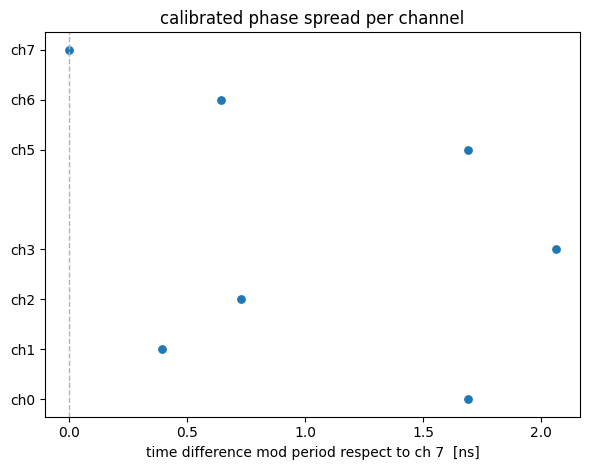

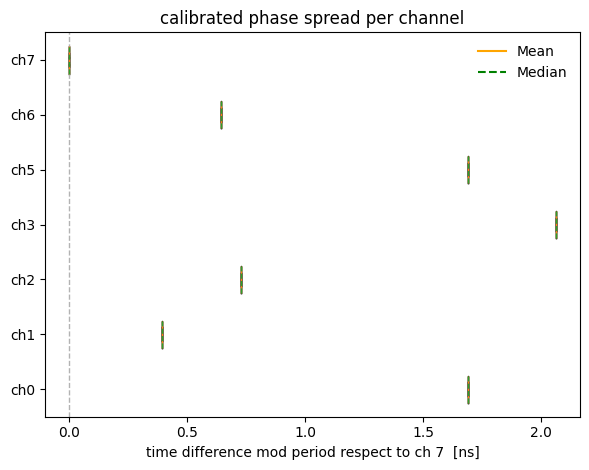

In [43]:
# t0 = datetime(2022, 9, 29, 23, 35, tzinfo=timezone.utc)
# t1 = datetime(2022, 9, 29, 23, 38, tzinfo=timezone.utc)
t0 = datetime(2022, 9, 29, 23, 19,41, tzinfo=timezone.utc)
t1 = datetime(2022, 9, 29, 23, 19,43, tzinfo=timezone.utc)

dt7_matrix_exp = load_dt7_results('dt7_results_run2205_narrow_filter.txt', t0, t1)
print(dt7_matrix_exp)
period=1./0.403
dt7_matrix_exp = dt7_matrix_exp.iloc[:,:8]

#print(dt7_matrix_exp)


df      = dt7_matrix_exp.copy()                  # safety first
lastcol = df.iloc[:, -1]                         # Series (row-wise broadcast)


# Step 1: subtract last element in each row
diff = df.iloc[:,1:].sub(lastcol, axis=0)                   # shape: (rows, 7)
# print(diff)


# Step 2: “wrap” the non-positive values by +period

dt7_exp_cali = diff.where(diff >= 0, diff + period)    # same shape, same labels
#print(dt7_exp_cali)


# Trigger-time column (still a Series, keeps the original dtype)
trigger_time = df.iloc[:, 0]

# Add it back as the first column
diff_matrix_with_time = pd.concat([trigger_time, dt7_exp_cali], axis=1)
#print(dt7_exp_cali)


def plot_dt7_vs_channel(dt7_values,
                        data_ch,
                        *,
                        title="calibrated phase spread per channel",
                        dt_unit="ns",
                        invert_y=False,
                        plot_type="scatter",
                        marker_kwargs=None,
                        box_kwargs=None,
                        show_zero=True,
                        jitter=0.08,
                        alpha=0.6):
    """
    Plot dt₇ vs channel as scatter or box, using *positional index* for dt7_values columns.

    Parameters
    ----------
    dt7_values : pandas.DataFrame or ndarray
        Columns correspond to channels in the same order as data_ch.
    data_ch : list[int]
        Logical channel numbers (labels), same order as dt7_values columns.
    """

    if marker_kwargs is None:
        marker_kwargs = dict(s=28)
    if box_kwargs is None:
        box_kwargs = dict(showfliers=False, showmeans=True, meanline=True)

    # Convert ndarray to DataFrame for consistent iloc
    if not hasattr(dt7_values, "iloc"):
        dt7_values = pd.DataFrame(dt7_values)

    fig, ax = plt.subplots(figsize=(6, 0.4*len(data_ch) + 2))

    if plot_type == "scatter":
        if len(dt7_values) == 1:
            vals = dt7_values.iloc[0, :].to_numpy()
            ax.scatter(vals, data_ch, **marker_kwargs)
        else:
            # loop over *positional* index j, channel label ch
            for j, ch in enumerate(data_ch):
                x = dt7_values.iloc[:, j].to_numpy()
                y = np.full_like(x, float(ch), dtype=float)
                if jitter:
                    y += np.random.uniform(-jitter, jitter, size=len(x))
                ax.scatter(x, y, alpha=alpha, **marker_kwargs)
        ax.set_yticks(data_ch)
        ax.set_yticklabels([f"ch{c}" for c in data_ch])

    elif plot_type == "box":
        data = [dt7_values.iloc[:, j].dropna().to_numpy()
                for j, _ in enumerate(data_ch)]
        bp = ax.boxplot(
            data,
            vert=False,
            labels=[f"ch{c}" for c in data_ch],
            **box_kwargs
        )
    
        # Add legend for mean (orange) and median (green dashed)
        legend_lines = [
            Line2D([0], [0], color='orange', lw=1.5, label='Mean'),
            Line2D([0], [0], color='green', lw=1.5, linestyle='--', label='Median')
        ]
        ax.legend(handles=legend_lines, loc='upper right', frameon=False)

    else:
        raise ValueError("plot_type must be 'scatter' or 'box'.")

    if show_zero:
        ax.axvline(0, color="0.7", lw=1, ls="--")
    ax.set_xlabel(f"time difference mod period respect to ch 7  [{dt_unit}]")
    ax.set_title(title)
    if invert_y:
        ax.invert_yaxis()
    fig.tight_layout()
    return ax


#print(data_ch)
#print(dt7_exp_cali)
plot_dt7_vs_channel(dt7_exp_cali, data_ch)
plot_dt7_vs_channel(dt7_exp_cali, data_ch,plot_type="box")
                    # invert_y=False,        # True if you want ch-7 on top
                    # marker_kwargs={'color': 'tab:blue', 's': 10})

based on the data refernce above, the data is  **[ -1/2 period, 1/2 period ]**

In [44]:
# --- parameters -------------------------------------------------
half_period = 0.5 * period            # threshold for the transformation

df=dt7_exp_cali.copy()
# --- transform: if value > 0.5 P  →  P - value ------------------
df[:] = np.where(df > half_period, df - period, df)

# --- median (“medium”) of each column ---------------------------
col_medians = df.median(axis=0)          # pandas Series

#print(df)
print(period)
print("Per-column medians after folding:")
print(col_medians.to_numpy())            # numpy array if you prefer

2.4813895781637716
Per-column medians after folding:
[-0.79280758  0.392581    0.72769    -0.42059758 -0.79120158  0.641621
  0.        ]


/tmp/ipykernel_683878/11449413.py:89: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


<Axes: title={'center': 'calibrated phase spread per channel, clustering adjusted period'}, xlabel='time difference mod period respect to ch 7  [ns]'>

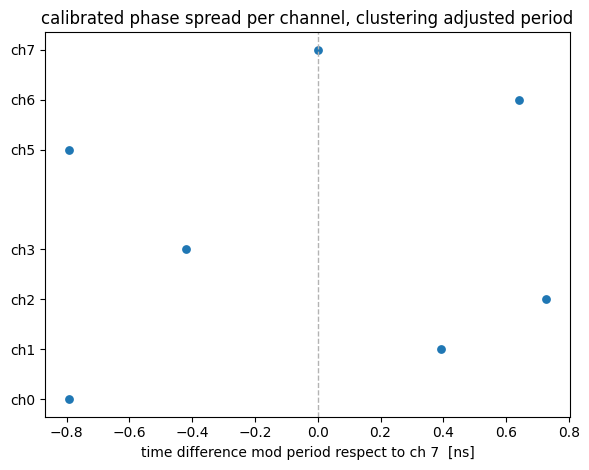

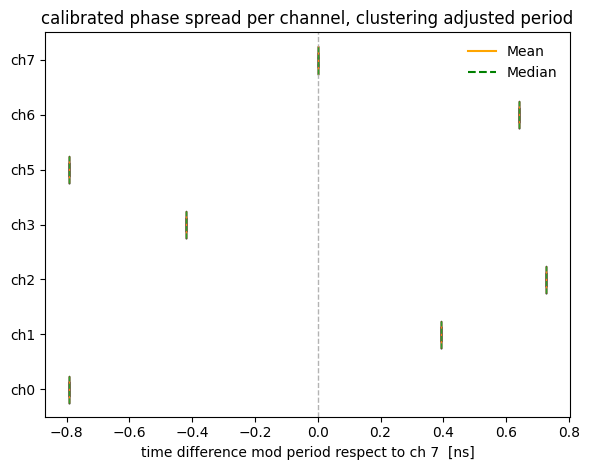

In [45]:
plot_dt7_vs_channel(df, data_ch,title="calibrated phase spread per channel, clustering adjusted period")
                    # invert_y=False,        # True if you want ch-7 on top
                    # marker_kwargs={'color': 'tab:blue', 's': 10})
plot_dt7_vs_channel(df, data_ch,plot_type="box",title="calibrated phase spread per channel, clustering adjusted period")

In [46]:
# ---------------- 2) ALIGN TO THEORY -----------------------------

# Make sure medians are in the *same* order as channels
#median_vec = col_medians.to_numpy()

# Two integer candidates around the “ideal” float multiplier
n_float = (dt7_poly_th.to_numpy() - col_medians.to_numpy()) / period
n_round= np.round(n_float)

dt7_exp_cali_adjusted = col_medians + n_round * period                   # final array

# ---------------- 3) OUTPUT --------------------------------------
#print("Channel order:", channels)
#print("col_medians  :", median_vec)
print("n integers   :", n_round)
print("Adjusted vals:", dt7_exp_cali_adjusted)


errs=[y-x for x,y in zip(dt7_exp_cali_adjusted[:-1],dt7_poly_th[:-1]) ]
print("error of the channel is:", errs)

print("Δt₇ errors out of 2.48s (ch7 vs …)\ngreenland_poly")
print(f"{'Pair':<10} | {'Error':>10}")
print("-" * 23)
for ch, err in zip(data_ch, errs):
    print(f"ch7 vs ch{ch:<2} | {err:>+9.2f}")
    

percent_err=[100*(1-x/y) for x,y in zip(dt7_exp_cali_adjusted[:-1],dt7_poly_th[:-1]) ]
print("error of the channel is:", percent_err)

print("Δt₇ percent errors (ch7 vs …)\ngreenland_poly")
print(f"{'Pair':<10} | {'Error (%)':>10}")
print("-" * 23)

for ch, err in zip(data_ch, percent_err):
    print(f"ch7 vs ch{ch:<2} | {err:>+9.2f}")

n integers   : [-126. -124. -121. -119.  -87.  -42.    0.]
Adjusted vals: dt0_ch0   -313.447894
dt0_ch1   -307.299727
dt0_ch2   -299.520449
dt0_ch3   -295.705957
dt0_ch5   -216.672095
dt0_ch6   -103.576741
dt0_ch7      0.000000
dtype: float64
error of the channel is: [1.184629426799006, 0.7524886923076792, -1.161871042183634, 0.6898193796525902, 0.508929878411891, 0.03217428287840107]
Δt₇ errors out of 2.48s (ch7 vs …)
greenland_poly
Pair       |      Error
-----------------------
ch7 vs ch0  |     +1.18
ch7 vs ch1  |     +0.75
ch7 vs ch2  |     -1.16
ch7 vs ch3  |     +0.69
ch7 vs ch5  |     +0.51
ch7 vs ch6  |     +0.03
error of the channel is: [-0.37936880817506236, -0.24547234456169242, 0.3864114930946516, -0.23382428647091835, -0.23543783623445336, -0.031072883696925402]
Δt₇ percent errors (ch7 vs …)
greenland_poly
Pair       |  Error (%)
-----------------------
ch7 vs ch0  |     -0.38
ch7 vs ch1  |     -0.25
ch7 vs ch2  |     +0.39
ch7 vs ch3  |     -0.23
ch7 vs ch5  |     -0.24


/tmp/ipykernel_683878/3064967206.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


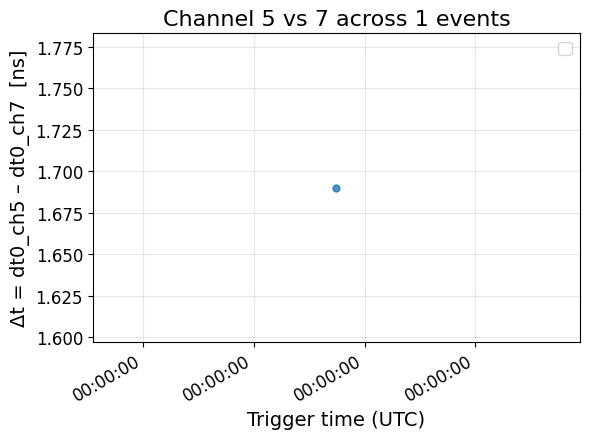

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ----------------------------------------------------------------------
#  NEW  ▸  Generic trigger-time-vs-Δt plotter
# ----------------------------------------------------------------------
def plot_dt_vs_time(
    df: pd.DataFrame | None = None,
    *,
    dt_matrix: np.ndarray | None = None,
    data_ch: list[int] | None = None,
    target_ch: int,
    ref_ch: int = 7,
    time_col: str = "TriggerTime(UTC)",
    dt_prefix: str = "dt0_ch",
) -> None:
    """
    Scatter-plot **(dt[target] – dt[ref])** versus trigger time.

    You may pass the data either as…

    1. **A pandas DataFrame** (``df``) with columns that begin with
       *dt_prefix* (e.g. “dt0_ch5”) *and* a column holding the trigger
       times (default “TriggerTime(UTC)”), **or**

    2. **A NumPy array** (``dt_matrix``) whose columns correspond to the
       channels listed in ``data_ch`` *plus* an iterable of trigger-time
       stamps inside the same ``df`` (handy when the times are already
       in your metadata table but the ∆t values came from somewhere
       else).

    Parameters
    ----------
    df : pandas.DataFrame | None
        Table that contains Δt columns and a trigger-time column.
    dt_matrix : numpy.ndarray | None
        Alternative input: 2-D array, shape (N_events, N_channels).
    data_ch : list[int] | None
        Channel labels corresponding to the columns of ``dt_matrix``.
    target_ch : int
        Channel you want on the y-axis.
    ref_ch : int, optional
        Reference channel.  Default is 7.
    time_col : str, optional
        Name of the trigger-time column in ``df``.  Ignored when
        ``df is None``.
    dt_prefix : str, optional
        Prefix in the Δt-column names, e.g. “dt0_ch”.
    """

    # ---------- sanity checks ----------
    if df is None and dt_matrix is None:
        raise ValueError("Supply either `df` *or* `dt_matrix`.")

    if dt_matrix is not None:
        if data_ch is None:
            raise ValueError("`data_ch` must accompany `dt_matrix`.")
        # locate the columns that correspond to the two channels
        try:
            idx_tar = data_ch.index(target_ch)
            idx_ref = data_ch.index(ref_ch)
        except ValueError as e:
            raise ValueError(f"Channel not found in data_ch: {e}")

        dt_diff = dt_matrix[:, idx_tar] - dt_matrix[:, idx_ref]
        trig_times = pd.to_datetime(df[time_col], utc=True)

    else:  # we have a DataFrame
        col_tar = f"{dt_prefix}{target_ch}"
        col_ref = f"{dt_prefix}{ref_ch}"
        for col in (col_tar, col_ref, time_col):
            if col not in df.columns:
                raise KeyError(f"Column ‘{col}’ not found in df")

        trig_times = pd.to_datetime(df[time_col], utc=True)
        dt_diff    = df[col_tar] - df[col_ref]

    # ---------- plot ----------
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(trig_times, dt_diff, s=25, alpha=0.8)

    ax.set_xlabel("Trigger time (UTC)", fontsize=14)
    ax.set_ylabel(f"Δt = dt0_ch{target_ch} – dt0_ch{ref_ch}  [ns]", fontsize=14)
    ax.set_title(
        f"Channel {target_ch} vs {ref_ch} across {len(dt_diff)} events", fontsize=16
    )

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    fig.autofmt_xdate()

    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_dt_vs_time(df=diff_matrix_with_time, target_ch=5) 


In [48]:
dt_poly_error = load_delay_matrix("subset_dt_poly_station_21_run_240594_theory_minus_expt.txt",3)
dt_simp_error = load_delay_matrix("subset_dt_simp_station_21_run_240594_theory_minus_expt.txt",3)

dt7_poly_err = dt_poly_error.iloc[7,data_ch]
dt7_simp_err = dt_simp_error.iloc[7,data_ch]
print(dt7_poly_err)
print(dt7_simp_err)

0   -0.838
1   -0.764
2   -0.844
3   -0.882
5   -0.951
6   -3.988
7    0.000
Name: 7, dtype: float64
0    3.731
1    3.777
2    3.667
3    3.599
5    2.961
6   -1.719
7    0.000
Name: 7, dtype: float64


In [49]:
def plot_depth_vs_dt(dx_ch_depth,
                     dt7_exp_cali_adjusted,
                     dt7_poly_th, 
                     #dt7_poly_err,
                     dt7_simp_th,
                     period,
                     *,
                     ch_order=None,
                     depth_unit='m',
                     dt_unit='s',
                     title="Comparison of Icemodel and Balloon data Time discrepancy (rel. ch 7)"):
    """
    Scatter-plot of calibrated experimental dt₇ plus two theory models,
    with faint ±period replicas of the experimental points.
    The x-axis is inverted so negative depths appear on the right.
    """
    # ---------- data --------------------------------------------------------
    x   = np.asarray(dx_ch_depth)
    y_e = np.asarray(dt7_exp_cali_adjusted)
    y_p = np.asarray(dt7_poly_th)
    y_s = np.asarray(dt7_simp_th)

    # downward-only error bars
    # neg_err = np.abs(np.asarray(dt7_poly_err))
    # yerr    = np.vstack([ np.zeros_like(neg_err),neg_err])   # shape (2, N)

    if ch_order is None:
        ch_order = list(range(len(x)))

    # ---------- figure ------------------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 4))

    # experimental (blue) + faint ghosts ±P
    ax.scatter(x, y_e, s=50, color='tab:blue', marker='o',
               label='Exp (calibrated)', zorder=4)
    ax.scatter(x, y_e + period, s=30, color='tab:blue', marker='o',
               alpha=0.25, zorder=2, label='_nolegend_')
    ax.scatter(x, y_e - period, s=30, color='tab:blue', marker='o',
               alpha=0.25, zorder=2, label='_nolegend_')

    # poly-theory (orange) with downward-only error bar  ➜ add label here
    ax.scatter(x, y_p, s=50, color='tab:orange', marker='s',
               label='Theory (poly)', zorder=3)
    # ax.errorbar(x, y_p, yerr=yerr, fmt='none',
    #             ecolor='tab:orange', capsize=4, lw=1, zorder=2,
    #             label='dt measured by pulser')   # <- new legend entry

    # simplified theory (green)
    ax.scatter(x, y_s, s=50, color='tab:green', marker='^',
               label='Theory (simp)', zorder=3)

    # annotate experimental points
    for cx, cy, ch in zip(x, y_e, ch_order):
        ax.text(cx, cy, f' ch{ch}', va='bottom', ha='left', fontsize=8)

    # invert x-axis so negative depths appear on the right
    ax.invert_xaxis()
    ax.set_xlim(-92, -96)        # x from 0 to 10
    ax.set_ylim(-280, -250)        # y from -1 to 1

    # decorations
    ax.set_xlabel(f'Depth  [{depth_unit}]', fontsize=14)
    ax.set_ylabel(f'Time difference dt₇ [{dt_unit}]', fontsize=14)
    ax.set_title(title, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    ax.grid(alpha=0.1)
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()


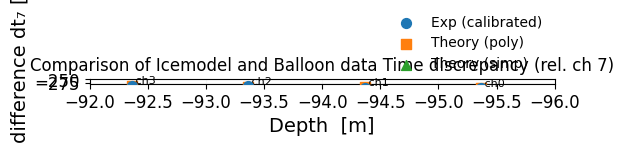

In [50]:
# plot_depth_vs_dt(dx_ch_depth,
#                  dt7_exp_cali_adjusted,
#                  dt7_poly_th,dt7_poly_err,
#                  dt7_simp_th,
#                  period,
#                  ch_order=data_ch,
#                  dt_unit='ns')     # or 'ns' after scaling if you wish
data_ch=[0,1,2,3]

plot_depth_vs_dt(dx_ch_depth,
                 dt7_exp_cali_adjusted,
                 dt7_poly_th,
                 dt7_simp_th,
                 period,
                 ch_order=data_ch,
                 dt_unit='ns')     # or 'ns' after scaling if you wish


In [51]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# def plot_depth_vs_dt(
#     dx_ch_depth,
#     dt7_exp_samples: pd.DataFrame,   # DataFrame: each column = one channel (same order as depths)
#     dt7_poly_th,
#     dt7_simp_th,
#     period,
#     *,
#     ch_order=None,                   # if None, labels come from df.columns (in order)
#     depth_unit='m',
#     dt_unit='ns',
#     title="Comparison of Icemodel and Balloon data Time discrepancy (rel. ch 7)",
#     n_boot=10_000,
#     ci=0.68,                           # allow 68 or 0.68
#     random_state=None,
#     return_offsets=False,            # if True, also return the integer shifts n_round
#     dt7_poly_err=None               # NEW: optional per-channel offsets to add to the median
# ):
#     """
#     Plot experimental dt₇ as bootstrap median ± CI (two-sided), then period-align to poly theory.
#     Also (optionally) plot an extra scatter at (median + dt7_poly_err) with no error bars.
#     """

#     # normalize CI: allow 0.68 or 68
#     ci_pct = float(ci) * (100.0 if (0 < ci <= 1) else 1.0)
#     if not (0 < ci_pct < 100):
#         raise ValueError("`ci` must be in (0,1) or (0,100).")

#     # ---------- inputs ----------
#     x   = np.asarray(dx_ch_depth, dtype=float)
#     y_p = np.asarray(dt7_poly_th, dtype=float)
#     y_s = np.asarray(dt7_simp_th, dtype=float)


    
#     if not isinstance(dt7_exp_samples, pd.DataFrame):
#         raise TypeError("dt7_exp_samples must be a pandas DataFrame with one column per channel.")

#     N_df = dt7_exp_samples.shape[1]
#     print(N_df)
    
#     if len(x) != N_df or len(y_p) != N_df or len(y_s) != N_df:
#         raise ValueError(
#             f"Length mismatch: depth={len(x)}, poly={len(y_p)}, simp={len(y_s)}, df_cols={N_df} "
#             "(these must match and be ordered the same)."
#         )

#     labels = list(dt7_exp_samples.columns) if ch_order is None else list(ch_order)

#     # RNG
#     rng = (random_state if isinstance(random_state, np.random.Generator)
#            else np.random.default_rng(random_state))

#     def _bootstrap_median(col_values, n_boot, ci_pct, rng):
#         v = np.asarray(col_values, dtype=float)
#         v = v[~np.isnan(v)]  # drop NaNs
#         if v.size == 0:
#             return np.nan, (np.nan, np.nan)
#         if v.size == 1:
#             m = float(v[0])
#             return m, (0.0, 0.0)

#         idx = rng.integers(0, v.size, size=(n_boot, v.size))
#         meds = np.median(v[idx], axis=1)
#         p_lo = (100 - ci_pct) / 2.0
#         p_hi = 100 - p_lo
#         lo, med, hi = np.percentile(meds, [p_lo, 50, p_hi])
#         return med, (med - lo, hi - med)

#     # Bootstrap each column → median & two-sided CI
#     medians, lo_err, hi_err = [], [], []
#     for j in range(N_df):
#         m, (elo, ehi) = _bootstrap_median(dt7_exp_samples.iloc[:, j].values, n_boot, ci_pct, rng)

#         medians.append(m); lo_err.append(elo); hi_err.append(ehi)
#     print(dt7_exp_samples.iloc[:, 1].values)
#     print(lo_err)
#     # keep a Series to align with df.columns for the period alignment step
#     col_medians = pd.Series(medians, index=dt7_exp_samples.columns, dtype=float)
#     yerr = np.vstack([np.asarray(lo_err, float), np.asarray(hi_err, float)])  # shape (2, N)


#     # print(col_medians)
    
#     # ---------- period adjustment (relative to poly theory) ----------
#     n_float = (y_p - col_medians.to_numpy()) / float(period)
#     n_round = np.rint(n_float).astype(int)     # nearest integer (ties-to-even)
#     y_e_adj = col_medians.to_numpy() + n_round * float(period)
#     # print(y_e_adj)
#     # print(y_p)
#     # ---------- optional extra scatter: median + dt7_poly_err ----------
#     extra_y = None
#     if dt7_poly_err is not None:
#         if isinstance(dt7_poly_err, pd.Series):
#             # align to df column order if index matches
#             # if not dt7_poly_err.index.equals(col_medians):
#             #     # reindex if possible; will raise if missing
#             #     dt7_poly_err = dt7_poly_err.reindex(dt7_exp_samples.columns)
#             err_arr = dt7_poly_err.to_numpy(dtype=float)
#             # print(err_arr)
#         else:
#             err_arr = np.asarray(dt7_poly_err, dtype=float)
#             if err_arr.shape != (N_df,):
#                 raise ValueError(f"dt7_poly_err must have length {N_df} (got {err_arr.shape}).")

#         extra_y = y_e_adj + err_arr   # no period adjustment on this series

    
#     # ---------- figure ----------
#     fig, ax = plt.subplots(figsize=(6, 4))

#     # experimental (period-adjusted) medians with regular (two-sided) error bars
#     ax.errorbar(
#         x, y_e_adj, yerr=yerr,
#         fmt='o', ms=6, color='tab:blue', ecolor='tab:blue',
#         elinewidth=1, capsize=4, label=f'dt_exp(median ±{ci_pct:.0f}%, nearest Period)', zorder=4
#     )

#     # optional extra scatter (median + dt7_poly_err), no error bars
#     if extra_y is not None:
#         ax.scatter(
#             x, extra_y, s=55, color='tab:red', marker='x',
#             zorder=4, label='Exp (median + pulser offset)'
#         )

#     # ±period ghosts around the *adjusted* medians
#     ax.scatter(x, y_e_adj - 2*period, s=30, color='tab:blue', marker='o', alpha=0.25, zorder=2, label='_next nearest Period_')
#     ax.scatter(x, y_e_adj + period, s=30, color='tab:blue', marker='o', alpha=0.25, zorder=2, label='near Period')
#     ax.scatter(x, y_e_adj - period, s=30, color='tab:blue', marker='o', alpha=0.25, zorder=2, label='_-1Period_')

#     # theory curves (no error bars)
#     ax.scatter(x, y_p, s=50, color='tab:orange', marker='s', label='Theory (greenland_poly)', zorder=3)
#     ax.scatter(x, y_s, s=50, color='tab:green',  marker='^', label='Theory (greenland_simp)', zorder=3)

#     # annotate experimental points using column labels (or ch_order if given)
#     for cx, cy, lab in zip(x, y_e_adj, labels):
#         ax.text(cx, cy, f' ch{lab}', va='bottom', ha='left', fontsize=8)

#     # x-axis: negative depths on the right
#     ax.invert_xaxis()

#     ax.set_xlabel(f'Depth offset wrt ch 7 [{depth_unit}]')
#     ax.set_ylabel(f'Time difference dt₇ [{dt_unit}]')
#     ax.set_title(title)
#     ax.grid(alpha=0.1)
#     ax.legend(frameon=False)
#     plt.tight_layout()
#     plt.show()

#     if return_offsets:
#         return y_e_adj, yerr, n_round
#     return y_e_adj, yerr


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_depth_vs_dt(
    dx_ch_depth,
    dt7_exp_samples: pd.DataFrame,   # DataFrame: each column = one channel (same order as depths)
    dt7_poly_th,
    dt7_simp_th,
    period,
    *,
    ch_order=None,                   # if None, labels come from df.columns (in order)
    depth_unit='m',
    dt_unit='ns',
    title="Comparison of Icemodel and Balloon data Time discrepancy (rel. ch 7)",
    return_offsets=False,            # if True, also return the integer shifts n_round
    ci=0.68,                         # unused (kept for compatibility)
    random_state=None,               # unused (kept for compatibility)
    dt7_poly_err=None               # NEW: optional per-channel offsets to add to the median
):
    """
    Plot experimental dt₇ as bootstrap median ± CI (two-sided), then period-align to poly theory.
    Also (optionally) plot an extra scatter at (median + dt7_poly_err) with no error bars.
    """

 # ---------- inputs ----------
    x   = np.asarray(dx_ch_depth, dtype=float)
    y_p = np.asarray(dt7_poly_th, dtype=float)
    y_s = np.asarray(dt7_simp_th, dtype=float)

    if not isinstance(dt7_exp_samples, pd.DataFrame):
        raise TypeError("dt7_exp_samples must be a pandas DataFrame with one column per channel.")

    N_df = dt7_exp_samples.shape[1]
    if len(x) != N_df or len(y_p) != N_df or len(y_s) != N_df:
        raise ValueError(
            f"Length mismatch: depth={len(x)}, poly={len(y_p)}, simp={len(y_s)}, df_cols={N_df} "
            "(these must match and be ordered the same)."
        )

    labels = list(dt7_exp_samples.columns) if ch_order is None else list(ch_order)

    # ---------- compute per-channel median and std ----------
    medians, sigmas = [], []
    for j in range(N_df):
        v = np.asarray(dt7_exp_samples.iloc[:, j].values, dtype=float)
        v = v[~np.isnan(v)]
        if v.size == 0:
            medians.append(np.nan)
            sigmas.append(np.nan)
        elif v.size == 1:
            medians.append(float(v[0]))
            sigmas.append(0.0)
        else:
            medians.append(float(np.median(v)))
            # sample std (unbiased) with ddof=1
            sigmas.append(float(np.std(v, ddof=1)))

    col_medians = pd.Series(medians, index=dt7_exp_samples.columns, dtype=float)
    sigmas = np.asarray(sigmas, dtype=float)
    yerr = np.vstack([sigmas, sigmas])  # symmetric ±1σ

    # ---------- period adjustment (relative to poly theory) ----------
    n_float = (y_p - col_medians.to_numpy()) / float(period)
    n_round = np.rint(n_float).astype(int)     # nearest integer (ties-to-even)
    y_e_adj = col_medians.to_numpy() + n_round * float(period)

    # ---------- optional extra scatter: median + dt7_poly_err ----------
    extra_y = None
    if dt7_poly_err is not None:
        if isinstance(dt7_poly_err, pd.Series):
            err_arr = dt7_poly_err.to_numpy(dtype=float)
        else:
            err_arr = np.asarray(dt7_poly_err, dtype=float)
            if err_arr.shape != (N_df,):
                raise ValueError(f"dt7_poly_err must have length {N_df} (got {err_arr.shape}).")
        extra_y = y_e_adj + err_arr   # no period adjustment on this series

    # ---------- figure ----------
    fig, ax = plt.subplots(figsize=(6, 4))

    # experimental (period-adjusted) medians with ±1σ error bars
    ax.errorbar(
        x, y_e_adj-y_p, yerr=yerr,
        fmt='o', ms=6, color='tab:blue', ecolor='tab:blue',
        elinewidth=1, capsize=4, label='dt_exp(median ±1σ, nearest Period)', zorder=4
    )

    # optional extra scatter (median + dt7_poly_err), no error bars
    if extra_y is not None:
        ax.scatter(
            x, extra_y, s=55, color='tab:red', marker='x',
            zorder=4, label='Exp (median + pulser offset)'
        )

    # ±period ghosts around the *adjusted* medians
    ax.scatter(x, y_e_adj-y_p - 2*period, s=30, color='tab:blue', marker='o', alpha=0.25, zorder=2, label='_next nearest Period_')
    ax.scatter(x, y_e_adj-y_p + period,  s=30, color='tab:blue', marker='o', alpha=0.25, zorder=2, label='near Period')
    ax.scatter(x, y_e_adj-y_p - period,  s=30, color='tab:blue', marker='o', alpha=0.25, zorder=2, label='_-1Period_')

    # theory curves (no error bars)
    ax.scatter(x, y_p-y_p, s=50, color='tab:orange', marker='s', label='Theory (greenland_poly)', zorder=3)
    ax.scatter(x, y_s-y_p, s=50, color='tab:green',  marker='^', label='Theory (greenland_simp)', zorder=3)

    # annotate experimental points using column labels (or ch_order if given)
    for cx, cy, lab in zip(x, y_e_adj-y_p, labels):
        ax.text(cx, cy, f' ch{lab}', va='bottom', ha='left', fontsize=8)

    # x-axis: negative depths on the right
    ax.invert_xaxis()

    ax.set_xlabel(f'Depth [{depth_unit}]', fontsize=14)
    ax.set_ylabel(f'Time difference dt₇ [{dt_unit}]', fontsize=14)
    ax.set_title(title, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    ax.grid(alpha=0.1)
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    if return_offsets:
        return y_e_adj, yerr, n_round
    return y_e_adj, yerr

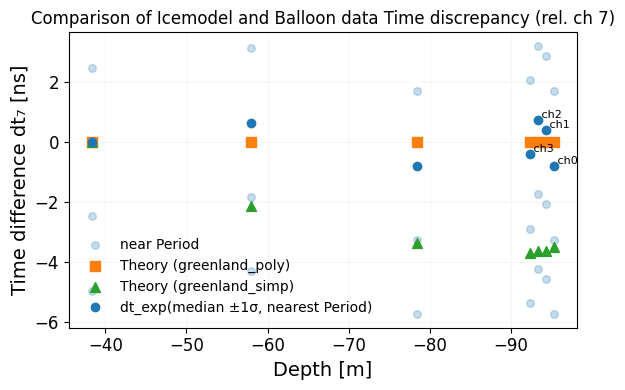

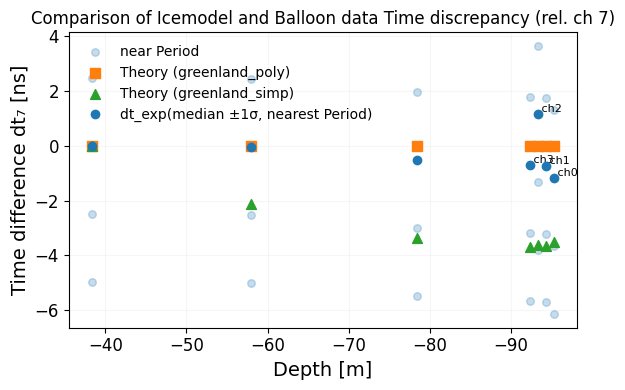

In [57]:
# depths: (N,)
# exp_samples: list of length N, each element is a 1-D array of samples for that depth
# poly_dt, simp_dt: (N,)
# nearest_dt: (N,) optional
#print(df)
# print(dt7_poly_err)
res = plot_depth_vs_dt(
    dx_ch_depth,
    dt7_exp_samples=df,
    dt7_poly_th=dt7_poly_th-dt7_poly_th,
    dt7_simp_th=dt7_simp_th-dt7_poly_th,
    ch_order=data_ch,
    period=period,
    ci=0.68,
    title="Comparison of Icemodel and Balloon data Time discrepancy (rel. ch 7)",
    # dt7_poly_err=dt7_poly_err
)



res = plot_depth_vs_dt(
    dx_ch_depth,
    dt7_exp_samples=df,
    dt7_poly_th=dt7_poly_th,
    dt7_simp_th=dt7_simp_th,
    ch_order=data_ch,
    period=period,
    ci=0.68,
    title="Comparison of Icemodel and Balloon data Time discrepancy (rel. ch 7)",
    # dt7_poly_err=dt7_poly_err
)